In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
print(np.__version__)
print(pd.__version__)

1.23.5
1.5.3


In [3]:
plt.style.use('ggplot')

In [4]:
# Colab does not have geopandas by default, would have to install
# (Otherwise run locally on your own computer)

import geopandas as gpd
# from shapely.geometry import Point

print(gpd.__version__)

0.12.2


# Toronto Fire Incidents
## Part 1: Data Preparation - Incident Wards
The following Jupyter notebook contains a part of the data preparation for the Toronto Fire Incidents (2011-2021) data set from https://open.toronto.ca/dataset/fire-incidents/ (last refreshed May 8, 2023 at the time of writing).

The boundary data set of the 25-Ward Model (`25-ward-model-december-2018-wgs84-latitude-longitude`) from https://open.toronto.ca/dataset/city-wards/ was also used to prepare the data.

This notebook contains information licensed under the Open Government Licence – Toronto.

## Table of Contents
- [1 Importing the Data](#1-importing-the-data)
    - [1.1 Toronto Fire Incidents](#11-toronto-fire-incidents)
    - [1.2 Ward Boundaries](#12-ward-boundaries)
- [2 Missing Coordinates](#2-missing-coordinates)
    - [2.1 Filling Missing Latitude and Longitude Values](#21-filling-missing-latitude-and-longitude-values)
    - [2.2 Drop Data Points Missing Coordinates](#22-drop-data-points-missing-coordinates)
- [3 Mapping the Fire Incidents](#3-mapping-the-fire-incidents)
    - [3.1 Mixed Incident Ward Values](#31-mixed-incident-ward-values)
- [4 Using the 25-Ward Model](#4-using-the-25-ward-model)
    - [4.1 Extra Data Points](#41-extra-data-points)
        - [4.1.1 Duplicated Without Same Ward](#411-duplicated-without-same-ward)
        - [4.1.2 Removing Duplicates With Different Ward](#412-removing-duplicates-with-different-ward)
    - [4.2 Mapping Fire Incidents with 25 Wards](#42-mapping-fire-incidents-with-25-wards)
- [5 Exporting CSV](#5-exporting-csv)
- [6 References](#6-references)

## 1 Importing the Data <a id="1-importing-the-data"/>
### 1.1 Toronto Fire Incidents <a id="11-toronto-fire-incidents"/>
Let us create a pandas DataFrame from the `.csv` file of the fire incidents data set from https://open.toronto.ca/dataset/fire-incidents/.

In [5]:
fire = pd.read_csv("data/Fire Incidents Data.csv")

We can check date range of the `TFS_Alarm_Time` column to confirm that the data set contains fire incidents from January 1, 2011 to December 31, 2021.

In [6]:
fire.TFS_Alarm_Time.agg([min, max])

min    2011-01-01T00:06:48
max    2021-12-31T23:37:37
Name: TFS_Alarm_Time, dtype: object

In [7]:
fire.head()

,_id,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,...,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,TFS_Firefighter_Casualties
0,1099441,81 - Engine Area,NaN,NaN,0.0,0.0,15000.0,NaN,NaN,2018-02-24T21:12:00,...,NaN,NaN,NaN,NaN,NaN,NaN,"7 - Fully involved (total structure, vehicle, ...",2018-02-24T21:04:29,2018-02-24T21:10:11,0.0
1,1099442,"75 - Trash, rubbish area (outside)",NaN,NaN,0.0,0.0,50.0,NaN,NaN,2018-02-24T21:29:42,...,NaN,NaN,NaN,NaN,NaN,NaN,2 - Fire with no evidence from street,2018-02-24T21:24:43,2018-02-24T21:29:31,0.0
2,1099443,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-25T13:29:59,2018-02-25T13:36:49,0.0
3,1099444,"75 - Trash, rubbish area (outside)",01 - Normal (no change),1 - No business interruption,0.0,0.0,0.0,0.0,NaN,2018-02-25T14:19:25,...,98 - Not applicable: Alarm operated OR presenc...,9 - Type undetermined,"8 - Not applicable: No alarm, no persons present",99 - Undetermined,8 - Not applicable - no sprinkler system present,9 - Undetermined,3 - Fire with smoke showing only - including v...,2018-02-25T14:13:39,2018-02-25T14:18:07,0.0
4,1099445,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-25T18:20:43,2018-02-25T18:26:19,0.0


We also notice that there are quite a few columns with about 10,000 null values. The `Exposure` feature seems to be missing the most values, where there are only 442/25860 non-null values (~1.7%).

We will explore the data in order to determine what is the best way to deal with these missing values.

In [8]:
fire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25860 entries, 0 to 25859
Data columns (total 43 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   _id                                                            25860 non-null  int64  
 1   Area_of_Origin                                                 20065 non-null  object 
 2   Building_Status                                                14285 non-null  object 
 3   Business_Impact                                                14283 non-null  object 
 4   Civilian_Casualties                                            25638 non-null  float64
 5   Count_of_Persons_Rescued                                       25637 non-null  float64
 6   Estimated_Dollar_Loss                                          20079 non-null  float64
 7   Estimated_Number_Of_Persons_Displaced                     

### 1.2 Ward Boundaries <a id="12-ward-boundaries"/>
Let us import the ward boundaries into a GeoDataFrame.

For this notebook, we used the `25-ward-model-december-2018-wgs84-latitude-longitude` data set from [https://open.toronto.ca/dataset/city-wards/](https://open.toronto.ca/dataset/city-wards/).

We will keep using the WGS84 (EPSG:4326) coordinate system here.

In [9]:
# Using the ward dataset from the City of Toronto's Open Data website:
wardzip = "data/25-ward-model-december-2018-wgs84-latitude-longitude/WARD_WGS84.shp"
wards = gpd.read_file(wardzip)

In [10]:
wards.head()

,AREA_ID,AREA_TYPE,AREA_S_CD,AREA_L_CD,AREA_NAME,X,Y,LONGITUDE,LATITUDE,geometry
0,2551040,WD18,16,16,Don Valley East,318237.290,4844000.0,-79.33298,43.739716,"POLYGON ((-79.31335 43.71699, -79.31950 43.715..."
1,2551044,WD18,03,03,Etobicoke-Lakeshore,303099.474,4831000.0,-79.52087,43.621646,"POLYGON ((-79.49777 43.65198, -79.49725 43.651..."
2,2551048,WD18,15,15,Don Valley West,314825.876,4843000.0,-79.37536,43.728396,"POLYGON ((-79.35232 43.71573, -79.35209 43.715..."
3,2551052,WD18,23,23,Scarborough North,324522.149,4852000.0,-79.25467,43.809672,"POLYGON ((-79.22591 43.83960, -79.22556 43.839..."
4,2551056,WD18,11,11,University-Rosedale,313306.543,4837000.0,-79.39432,43.671139,"POLYGON ((-79.39004 43.69050, -79.39004 43.690..."


## 2 Missing Coodinates <a id="2-missing-coordinates"/>
Let us address the data points with missing coordinates.

We can see there are data points with missing `Longitude` and `Latitude` values. These data points also appears to be missing values in many of the other categories, including columns that would indicate geographic information, such as `Incident_Ward` and `Intersection`.

In [11]:
fire[fire.Longitude.isna() | fire.Latitude.isna()]

,_id,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,...,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,TFS_Firefighter_Casualties
18863,1118304,81 - Engine Area,NaN,NaN,0.0,0.0,3000.0,NaN,NaN,2011-09-26T19:03:00,...,NaN,NaN,NaN,NaN,NaN,NaN,3 - Fire with smoke showing only - including v...,2011-09-26T18:55:12,2011-09-26T19:01:00,0.0
19007,1118448,24 - Cooking Area or Kitchen,NaN,NaN,0.0,NaN,100.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1 - Fire extinguished prior to arrival,2020-08-26T07:00:00,NaN,0.0


### 2.1 Filling Missing Latitude and Longitude Values <a id="21-filling-missing-latitude-and-longitude-values"/>
One of the data points has a non-null value in `Incident_Station_Area`

We can use this information to try to fill in the missing `Longitude` and `Latitude` coordinates.

In [12]:
fire[fire.Latitude.isna() | fire.Longitude.isna()][['Incident_Station_Area', 'Incident_Ward', 'Latitude', 'Longitude']]

,Incident_Station_Area,Incident_Ward,Latitude,Longitude
18863,214.0,NaN,NaN,NaN
19007,NaN,NaN,NaN,NaN


We can look at other data points with the same `Incident_Station_Area`. We notice that there seems to be multiple `Incident_Ward` values associated with this `Incident_Station_Area`. More on this later.

In [13]:
fire[fire.Incident_Station_Area == 214].groupby('Incident_Ward')['Incident_Ward'].count()

Incident_Ward
24.0     5
25.0    82
42.0     2
43.0    14
44.0    85
Name: Incident_Ward, dtype: int64

Let us plot the other incidents in the same `Incident_Station_Area`.

We can see that these other data points occured in roughly the same area in the east end of the city.

We can fill in the missing `Latitude` and `Longitude` value of the data point using the average coordinates of the data points recorded with the same `Incident_Station_Area` as an approximation.

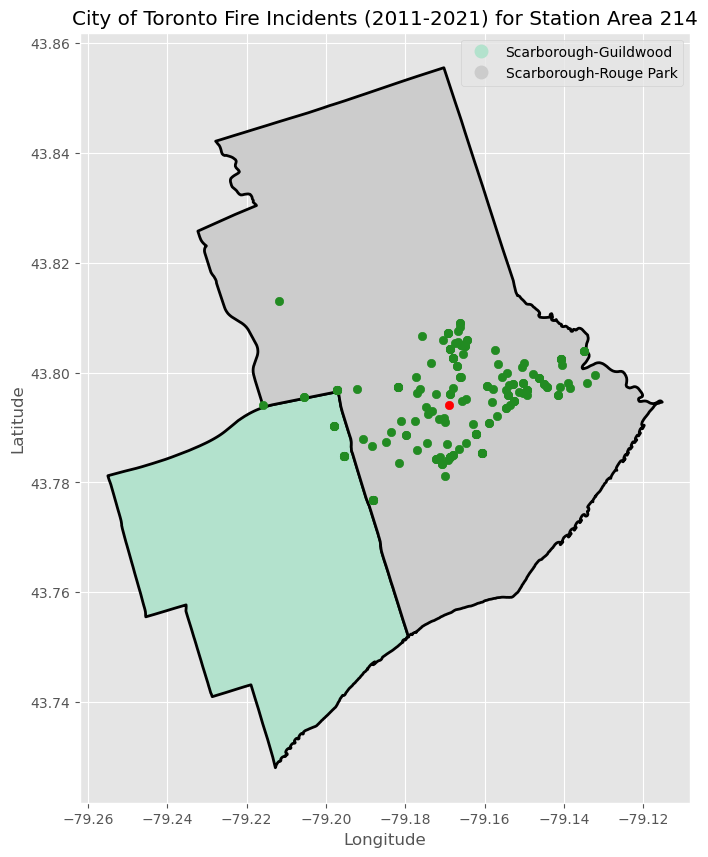

In [14]:
wardstn214 = wards[wards.AREA_S_CD.isin(['24', '25'])]

f, ax = plt.subplots(figsize=(15,10))
wardstn214.plot(ax=ax, column='AREA_NAME', cmap='Pastel2', edgecolor="black",  linewidth = 2, legend=True)

ax.scatter(x='Longitude', y='Latitude', data=fire[fire.Incident_Station_Area == 214], color='forestgreen', label='Fire Incident')
ax.scatter(x='Longitude', y='Latitude', data=fire[fire.Incident_Station_Area == 214][['Latitude', 'Longitude']].mean(),
                     color = 'red',
                     label='Average')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('City of Toronto Fire Incidents (2011-2021) for Station Area 214');

In [15]:
# Replace the Latitude and Longitude values for the one data point with Incident Station Area 214
fire.loc[18863, ['Latitude', 'Longitude']] = fire[fire.Incident_Station_Area == 214][['Latitude', 'Longitude']].mean()

In [16]:
fire.loc[18863, ['Latitude', 'Longitude']]

Latitude     43.794027
Longitude    -79.16904
Name: 18863, dtype: object

### 2.2 Drop Data Points Missing Coordinates <a id="22-drop-data-points-missing-coordinates"/>
The other data point does not have any other geographic information suggesting where the incident may have occurred. It also appears to be missing a lot of information in other columns, including `TFS_Arrival_Time`.

Since it may be difficult to fill in the information for this data point, we can choose to drop it.

In [17]:
fire = fire.dropna(subset=['Latitude', 'Longitude'])

## 3 Mapping the Fire Incidents <a id="3-mapping-the-fire-incidents"/>
Let us plot where fire incidents have occurred in Toronto along with the ward boundaries for spatial orientation.

We will generate a `GeoDataFrame` using `GeoPandas`, where the geographic information is given by the `Latitude` and `Longitude` columns.

In [18]:
firegdf = gpd.GeoDataFrame(fire, geometry = gpd.points_from_xy(fire.Longitude, fire.Latitude), crs=4326)

Alternatively, we could have create a `geometry` column by converting the `Longitude` and `Latitude` values into Shapely Points.

In [19]:
# Going with the assumption that the longitude/latitude coordinates are using the WGS84 Coordinate System

# fire['geometry'] = list(zip(fire.Longitude, fire.Latitude))
# fire['geometry'] = fire['geometry'].apply(Point)
# firegdf = gpd.GeoDataFrame(fire, crs=4326)

In [20]:
firegdf.head()

,_id,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,...,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,TFS_Firefighter_Casualties,geometry
0,1099441,81 - Engine Area,NaN,NaN,0.0,0.0,15000.0,NaN,NaN,2018-02-24T21:12:00,...,NaN,NaN,NaN,NaN,NaN,"7 - Fully involved (total structure, vehicle, ...",2018-02-24T21:04:29,2018-02-24T21:10:11,0.0,POINT (-79.59942 43.68656)
1,1099442,"75 - Trash, rubbish area (outside)",NaN,NaN,0.0,0.0,50.0,NaN,NaN,2018-02-24T21:29:42,...,NaN,NaN,NaN,NaN,NaN,2 - Fire with no evidence from street,2018-02-24T21:24:43,2018-02-24T21:29:31,0.0,POINT (-79.39004 43.76613)
2,1099443,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-25T13:29:59,2018-02-25T13:36:49,0.0,POINT (-79.24506 43.74323)
3,1099444,"75 - Trash, rubbish area (outside)",01 - Normal (no change),1 - No business interruption,0.0,0.0,0.0,0.0,NaN,2018-02-25T14:19:25,...,9 - Type undetermined,"8 - Not applicable: No alarm, no persons present",99 - Undetermined,8 - Not applicable - no sprinkler system present,9 - Undetermined,3 - Fire with smoke showing only - including v...,2018-02-25T14:13:39,2018-02-25T14:18:07,0.0,POINT (-79.47806 43.70866)
4,1099445,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-25T18:20:43,2018-02-25T18:26:19,0.0,POINT (-79.44318 43.71812)


We can create a function to help us plot our data points and the ward boundaries.

In [21]:
def plot_map(ward_gdf, fire_gdf, groupby_firecolumn, title, markersize=1, alpha=1, figsize=(15,10)):
    '''Generates a plot of the wards and fire incident data points.
    
    Parameters
    ----------
    ward_gdf : GeoDataFrame
        GeoDataFrame containing the ward boundaries to be drawn.
    fire_gdf : GeoDataFrame
        GeoDataFrame containing the fire incident data points to be plotted.
    groupby_firecolumn : str
        Column name in fire_gdf to be used to colour data points.
    title : str
        Title to be given to the figure.
    markersize : float, default 1
        matplotlib parameter to set fire incident marker size.
    alpha : float, default 1
        matplotlib parameter to set fire incident marker alpha.
        alpha must be within the 0-1 range, inclusive.
    figsize : 2-tuple of floats, default (15, 10)
    
    Returns
    -------
    f : Figure
    ax : Axes
    '''
    
    f, ax = plt.subplots(figsize=figsize)
    ward_gdf.plot(ax=ax, color='white', edgecolor="black",  linewidth = 2)
    fire_gdf.plot(ax=ax, column = groupby_firecolumn, cmap = "prism", markersize=markersize, alpha=alpha)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(title)
    
    return f, ax

### 3.1 Mixed Incident Ward Values <a id="31-mixed-incident-ward-values"/>
When the fire incidents are coloured by `Incident_Ward`, the different coloured points do not appear to be clearly separated by the ward boundaries.

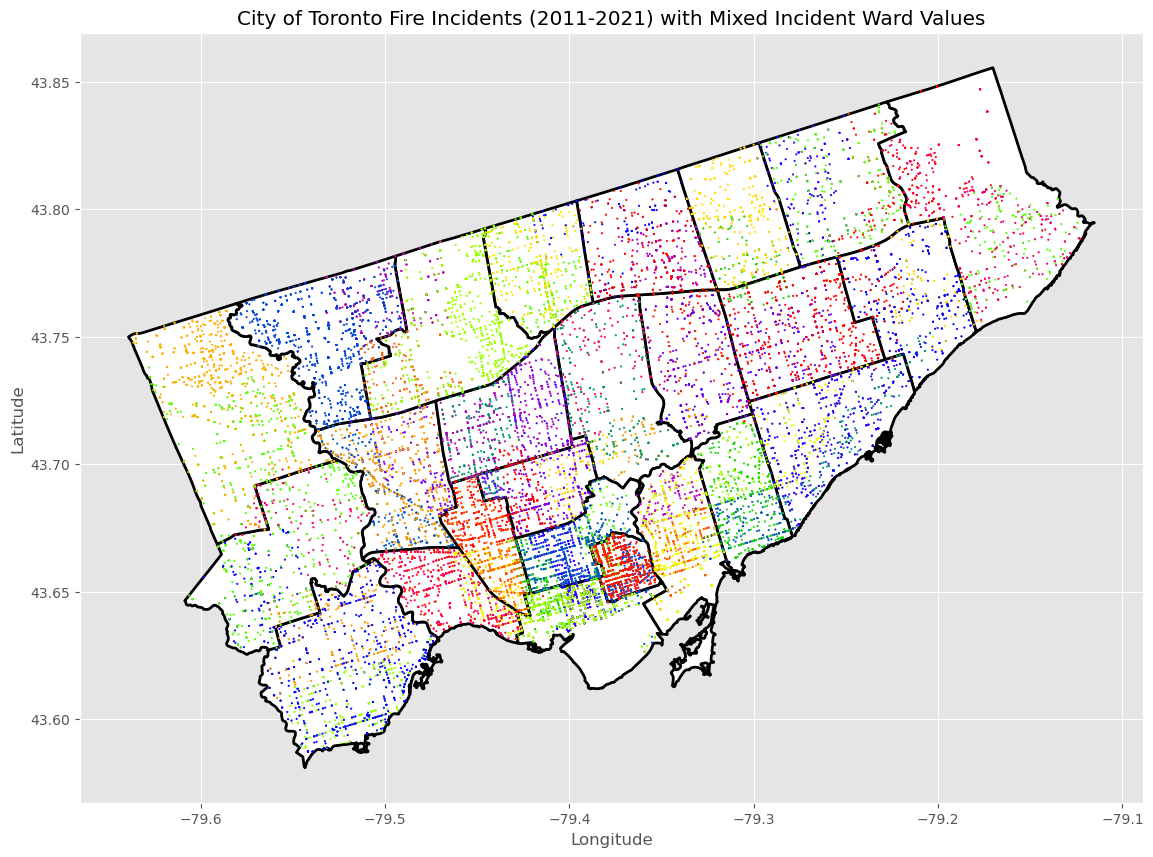

In [22]:
# Plotting the points to see if they fall in the corresponding ward boundaries
plot_map(wards,
         firegdf,
         "Incident_Ward",
         "City of Toronto Fire Incidents (2011-2021) with Mixed Incident Ward Values");
plt.savefig('images/mixedwards.png', bbox_inches='tight')

We can see incidents occurring at the same `Intersection` may be recorded with different `Incident_Ward` values.

In the sample below, we notice that the data points at the `Kennedy Rd / McNicoll Ave` were recorded with `Incident_Ward` 22 from 2018 onwards, whereas those before 2018 were recorded with `Incident_Ward` 39.

In [23]:
fire[fire.Intersection == 'Kennedy Rd / McNicoll Ave'][['Incident_Ward', 'Intersection', 'TFS_Alarm_Time']]

,Incident_Ward,Intersection,TFS_Alarm_Time
4393,22.0,Kennedy Rd / McNicoll Ave,2019-01-04T09:22:52
4742,22.0,Kennedy Rd / McNicoll Ave,2018-08-31T18:50:04
9614,39.0,Kennedy Rd / McNicoll Ave,2012-05-06T12:43:27
18736,39.0,Kennedy Rd / McNicoll Ave,2012-11-01T19:00:25
22732,22.0,Kennedy Rd / McNicoll Ave,2019-08-04T17:53:28
25400,22.0,Kennedy Rd / McNicoll Ave,2021-06-24T04:27:41


## 4 Using the 25-Ward Model <a id="4-using-the-25-ward-model"/>
In 2018, the number of Toronto city wards was reduced from 44 to 25. We have seen that the data set contains a mixture of both ward models. In order to correct for inconsistencies, we will use `GeoPandas` to remap the fire incidents to the new wards. Doing so will also help us assign wards to any data points missing `Incident_Ward` values by using their `Longitude` and `Latitude` values.

We will first convert from the geographic coordinate systems (GCS) to a projected coordinate system (PCS) for better accuracy while using the GeoPandas `sjoin_nearest` tool.

Since our data points are located within Toronto, we can use the [MTM Zone 10](https://epsg.io/32190-to-4326) coordinate system (EPSG code 32190), which includes the longitude values between 81°W and 78°W in the area south of 46°N within Canada.

In [24]:
fire[['Latitude', 'Longitude']].agg([min, max])

,Latitude,Longitude
min,43.587316,-79.636530
max,43.855400,-79.123103


In [25]:
# Convert to MTM Zone 10
wards = wards.to_crs(epsg=32190)
firegdf = firegdf.to_crs(crs=wards.crs)

We will use `sjoin_nearest`, since `sjoin` appears to miss edge cases when points lie on polygon boundaries. We will use a `left join` to ensure all fire incident data points are included.

Note: we have cleaned the data set so that each data point has a set of geographic coordinates to be used with `sjoin_nearest`.

In [26]:
fireward = gpd.sjoin_nearest(firegdf, wards[["AREA_S_CD", "AREA_NAME", "geometry"]], how="left")
fireward = fireward.rename(columns={"AREA_S_CD":"New_Ward", "AREA_NAME": "Ward_Name"})
fireward.New_Ward = fireward.New_Ward.astype(int)

In [27]:
fireward.head()

,_id,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,...,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,TFS_Firefighter_Casualties,geometry,index_right,New_Ward,Ward_Name
0,1099441,81 - Engine Area,NaN,NaN,0.0,0.0,15000.0,NaN,NaN,2018-02-24T21:12:00,...,NaN,NaN,"7 - Fully involved (total structure, vehicle, ...",2018-02-24T21:04:29,2018-02-24T21:10:11,0.0,POINT (296784.999 4838517.069),11,1,Etobicoke North
1,1099442,"75 - Trash, rubbish area (outside)",NaN,NaN,0.0,0.0,50.0,NaN,NaN,2018-02-24T21:29:42,...,NaN,NaN,2 - Fire with no evidence from street,2018-02-24T21:24:43,2018-02-24T21:29:31,0.0,POINT (313653.256 4847358.800),20,18,Willowdale
2,1099443,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2018-02-25T13:29:59,2018-02-25T13:36:49,0.0,POINT (325333.639 4844839.914),15,21,Scarborough Centre
3,1099444,"75 - Trash, rubbish area (outside)",01 - Normal (no change),1 - No business interruption,0.0,0.0,0.0,0.0,NaN,2018-02-25T14:19:25,...,8 - Not applicable - no sprinkler system present,9 - Undetermined,3 - Fire with smoke showing only - including v...,2018-02-25T14:13:39,2018-02-25T14:18:07,0.0,POINT (306568.036 4840967.847),7,5,York South-Weston
4,1099445,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2018-02-25T18:20:43,2018-02-25T18:26:19,0.0,POINT (309378.090 4842020.054),9,8,Eglinton-Lawrence


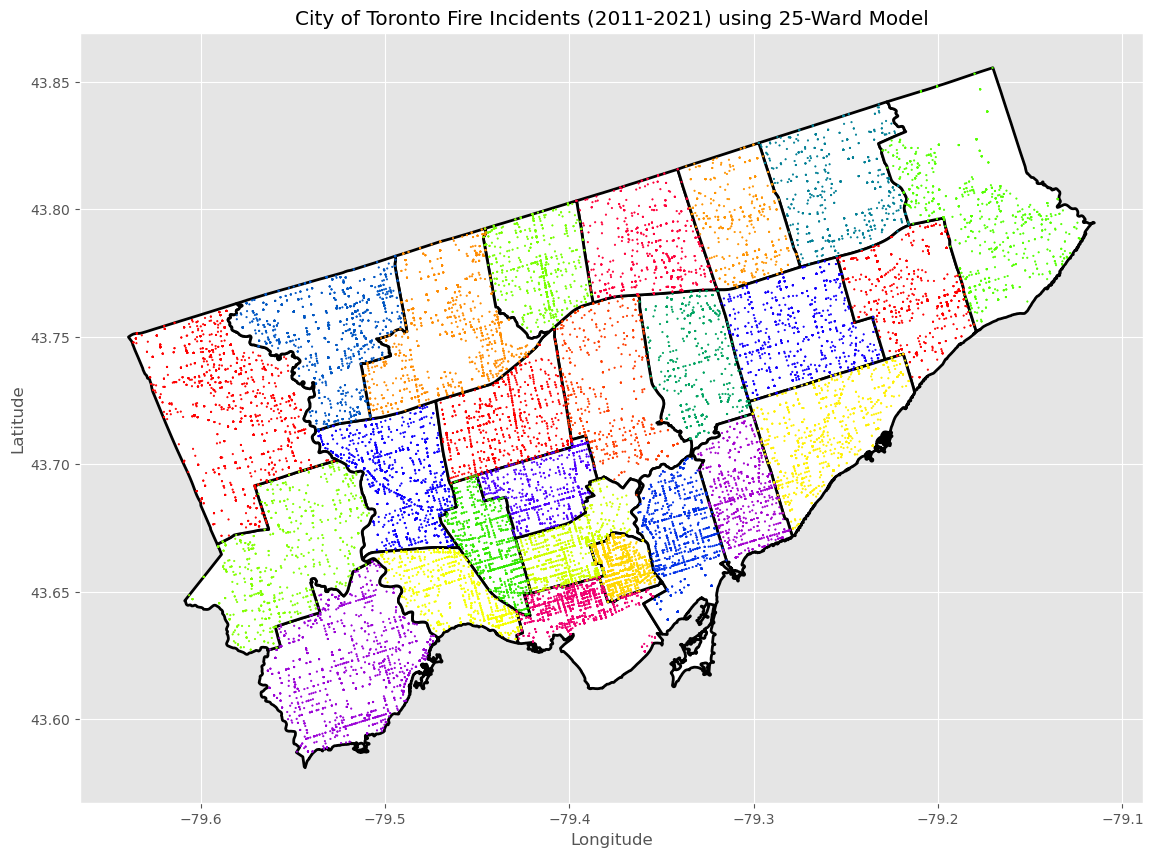

In [28]:
# If we want to convert back to geographic coordinates:
wards = wards.to_crs(epsg=4326)
fireward = fireward.to_crs(epsg=4326)

# Plot the incidents grouped by new wards
plot_map(wards,
         fireward,
         "New_Ward",
         "City of Toronto Fire Incidents (2011-2021) using 25-Ward Model");

### 4.1 Extra Data Points <a id="41-extra-data-points"/>
We can see that we now have more points than we started with. Let us take a look at the data points that were duplicated. These data points will have duplicated index values.

In [29]:
fireward.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 26013 entries, 0 to 25859
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype   
---  ------                                                         --------------  -----   
 0   _id                                                            26013 non-null  int64   
 1   Area_of_Origin                                                 20140 non-null  object  
 2   Building_Status                                                14335 non-null  object  
 3   Business_Impact                                                14333 non-null  object  
 4   Civilian_Casualties                                            25789 non-null  float64 
 5   Count_of_Persons_Rescued                                       25789 non-null  float64 
 6   Estimated_Dollar_Loss                                          20154 non-null  float64 
 7   Estimated_Number_Of_Persons_Displaced    

In [30]:
firedup = fireward[fireward.index.duplicated(keep=False)]
firedup[['Incident_Ward', 'New_Ward']]

,Incident_Ward,New_Ward
8,10.0,10
8,10.0,13
31,12.0,11
31,12.0,12
32,11.0,11
...,...,...
25347,11.0,13
25592,11.0,11
25592,11.0,13
25609,24.0,21


We can see that the points that are mapped to multiple `New_Ward` values were incidents recorded with coordinates that lie on the 25-ward model boundaries.

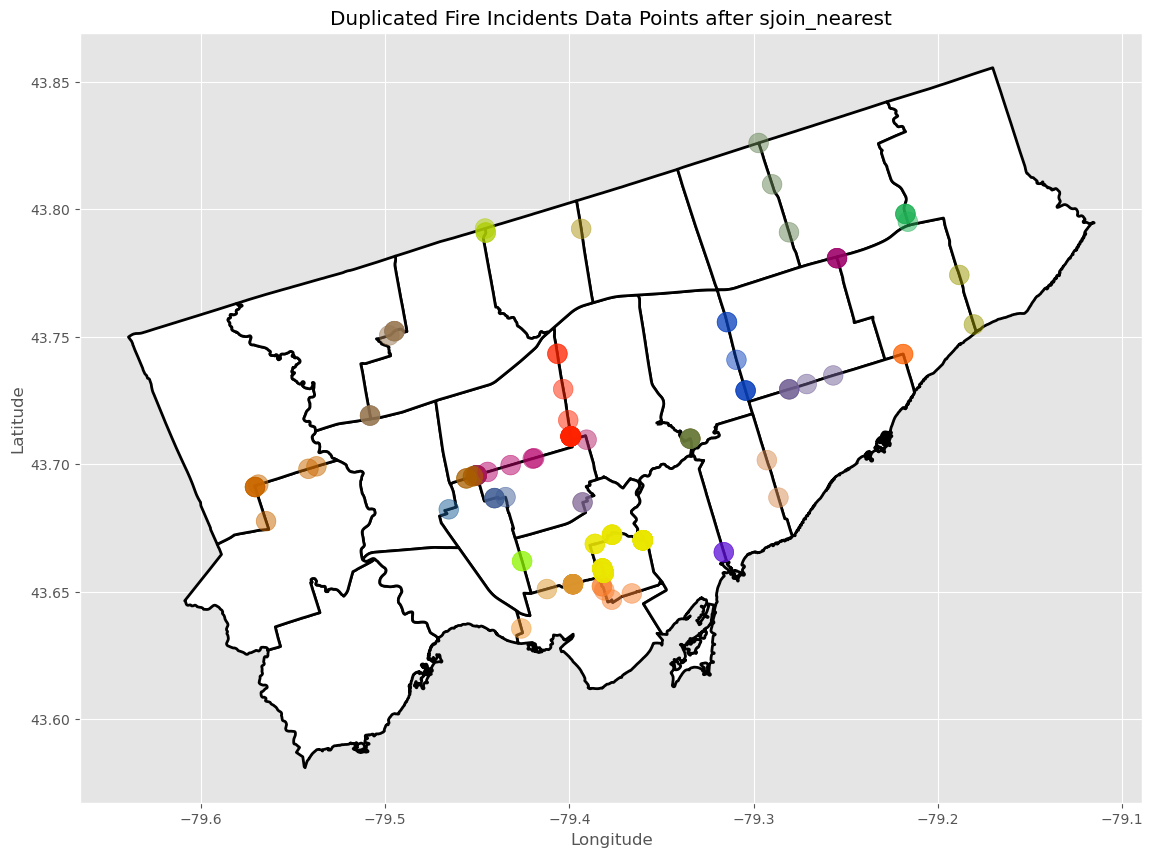

In [31]:
plot_map(wards, 
         firedup,
         "New_Ward",
         "Duplicated Fire Incidents Data Points after sjoin_nearest",
         markersize=200,
         alpha = 0.3);

We can separate these duplicated rows into two groups, depending on whether or not the row has `Incident_Ward` and `New_Ward` as the same value.

In [32]:
# Get all incidents that were duplicated and have the same ward as previously assigned
dup_sameward = firedup[firedup.Incident_Ward == firedup.New_Ward]
dup_sameward[['Incident_Ward','New_Ward']]

,Incident_Ward,New_Ward
8,10.0,10
31,12.0,12
32,11.0,11
48,12.0,12
185,1.0,1
...,...,...
24743,11.0,11
25263,11.0,11
25347,11.0,11
25592,11.0,11


In [33]:
# Get all incidents that were duplicated and have a different ward than previously assigned
dup_diffward = firedup[firedup.Incident_Ward != firedup.New_Ward]
dup_diffward[['Incident_Ward','New_Ward']]

,Incident_Ward,New_Ward
8,10.0,13
31,12.0,11
32,11.0,13
48,12.0,15
185,1.0,2
...,...,...
24743,11.0,13
25263,11.0,13
25347,11.0,13
25592,11.0,13


We can see that for most of the fire incidents with duplicated ward values (same index), there is:
- At least one row where `Incident_Ward` is the same as `New_Ward`
- At least one row where `Incident_Ward` is not the same as `New_Ward`

Since all the duplicated rows were also mapped to the original ward value in `Incident_Ward`, we may prefer using this ward and drop the other values.

In [34]:
print('Number of duplicated indices in dup_sameward:', sum(dup_sameward.index.duplicated()))
print('Number of duplicated indices in dup_diffward:', sum(dup_diffward.index.duplicated()))
print('Number of indices in firedup not in dup_sameward:', len(set(firedup.index) - set(dup_sameward.index)))
print('Number of indices in firedup not in dup_diffward:', len(set(firedup.index) - set(dup_diffward.index)))

Number of duplicated indices in dup_sameward: 0
Number of duplicated indices in dup_diffward: 5
Number of indices in firedup not in dup_sameward: 1
Number of indices in firedup not in dup_diffward: 0


#### 4.1.1 Duplicated Without Same Ward <a id="411-duplicated-without-same-ward"/>
There appears to be one data point where none of the duplicated rows have `Incident_Ward` == `New_Ward`.

In [35]:
set(firedup.index) - set(dup_sameward.index)

{21485}

Here we can see the data point straddles on the border of `York Centre` and `Willowdale` and has a null `Incident_Ward` value.

There are other data points with null `Incident_Ward` values. However, these data points may not have been duplicated because they did not occur on the ward boundaries.

In [36]:
firedup.loc[21485][['Incident_Ward','New_Ward', 'Ward_Name', 'Incident_Station_Area']]

,Incident_Ward,New_Ward,Ward_Name,Incident_Station_Area
21485,NaN,6,York Centre,112.0
21485,NaN,18,Willowdale,112.0


When we look at other incidents occurring in the same `Incident_Station_Area` (112), we see that roughly the same number of incidents occurred in Willowdale and York Centre.

In [37]:
fireward[fireward.Incident_Station_Area == 112].groupby('Ward_Name')['Ward_Name'].count()

Ward_Name
Willowdale     154
York Centre    159
Name: Ward_Name, dtype: int64

We can plot these incidents to see where the fire incidents related to `Incident_Station_Area` 112 occurred.

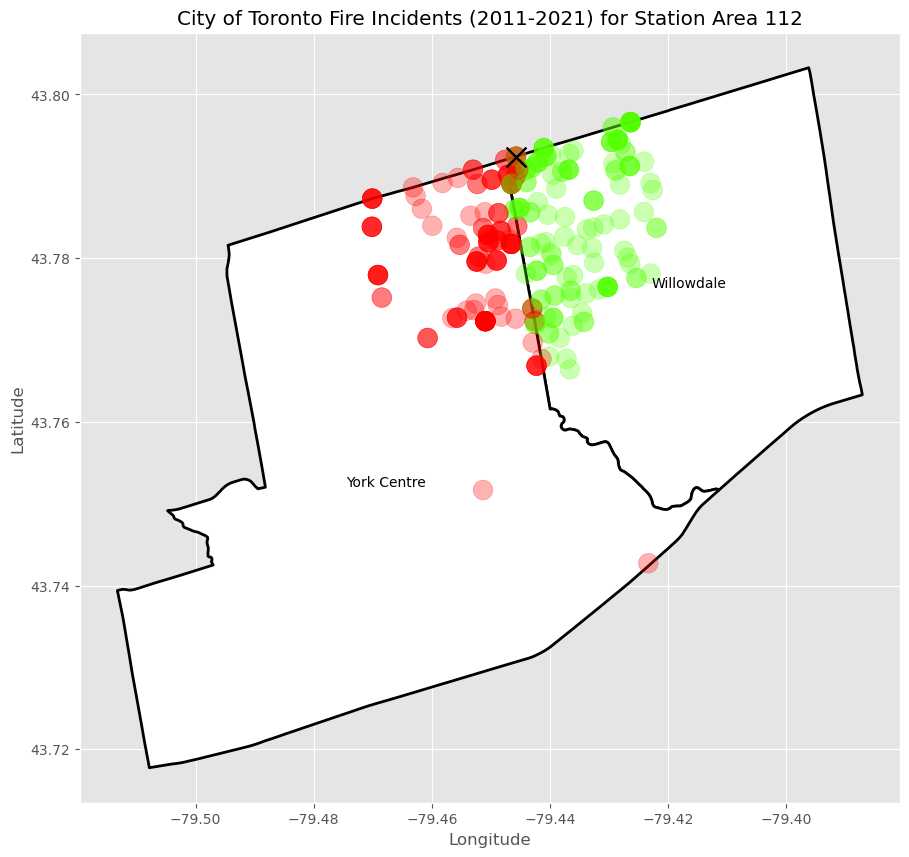

In [38]:
willyork = wards[wards.AREA_NAME.isin(['York Centre', 'Willowdale'])]

f, ax = plot_map(willyork, 
                 fireward[fireward.Incident_Station_Area == 112], 
                 "New_Ward", "City of Toronto Fire Incidents (2011-2021) for Station Area 112", 
                 markersize=200, 
                 alpha = 0.3)

for idx, val in willyork.iterrows():
    ax.text(val['LONGITUDE'], val['LATITUDE'], val['AREA_NAME'],
             horizontalalignment='center',
             verticalalignment='center')

# Plot the data point with duplicated values with an x
firedup.loc[21485].plot(ax = ax, color='k', marker='x', markersize=200);

When we look at the data point closely, we can see that this also appears to be missing a lot of the values in the other columns. This incident does not appear to have been very severe, since it was recorded as a `NO LOSS OUTDOOR fire`.

In [39]:
firedup.loc[21485]

,_id,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,...,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,TFS_Firefighter_Casualties,geometry,index_right,New_Ward,Ward_Name
21485,1120926,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2019-10-02T18:43:08,2019-10-02T18:48:59,0.0,POINT (-79.44576 43.79241),21,6,York Centre
21485,1120926,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2019-10-02T18:43:08,2019-10-02T18:48:59,0.0,POINT (-79.44576 43.79241),20,18,Willowdale


In [40]:
firedup.loc[21485]['Final_Incident_Type']

21485    03 - NO LOSS OUTDOOR fire (exc: Sus.arson,vand...
21485    03 - NO LOSS OUTDOOR fire (exc: Sus.arson,vand...
Name: Final_Incident_Type, dtype: object

In this case, we could assign this data point to either ward, since it does not seem like it would really impact the analysis in any significant way.

We will arbitrarily relabel the `Incident_Ward` of this point to Willowdale (Ward 18).

In [41]:
fireward.loc[21485, 'Incident_Ward'] = 18

#### 4.1.2 Removing Duplicates With Different Ward <a id="412-removing-duplicates-with-different-ward"/>
Now, all of the duplicated rows in our DataFrame are now recorded with at least one row where `Incident_Ward` == `New_Ward`.

In the case of duplicates, we might prefer the original ward value from `Incident_Ward` over a different one mapped by `sjoin_nearest`. Therefore, we will remove the duplicates where `Incident_Ward` != `New_Ward`.

In [42]:
# Removing the duplicates found above but keeping the ones with "New_Ward" == "Incident_Ward"
fireward = fireward[~((fireward._id.duplicated(keep=False)) & (fireward.Incident_Ward != fireward.New_Ward.astype(float)))]

In [43]:
# Verifying, it has the same number of entries as the original fire dataset
fireward.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 25859 entries, 0 to 25859
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype   
---  ------                                                         --------------  -----   
 0   _id                                                            25859 non-null  int64   
 1   Area_of_Origin                                                 20064 non-null  object  
 2   Building_Status                                                14285 non-null  object  
 3   Business_Impact                                                14283 non-null  object  
 4   Civilian_Casualties                                            25637 non-null  float64 
 5   Count_of_Persons_Rescued                                       25637 non-null  float64 
 6   Estimated_Dollar_Loss                                          20078 non-null  float64 
 7   Estimated_Number_Of_Persons_Displaced    

### 4.2 Mapping Fire Incidents with 25 Wards <a id="42-mapping-fire-incidents-with-25-wards"/>
Now that we have removed the duplicate values, we can visualize our data once again.

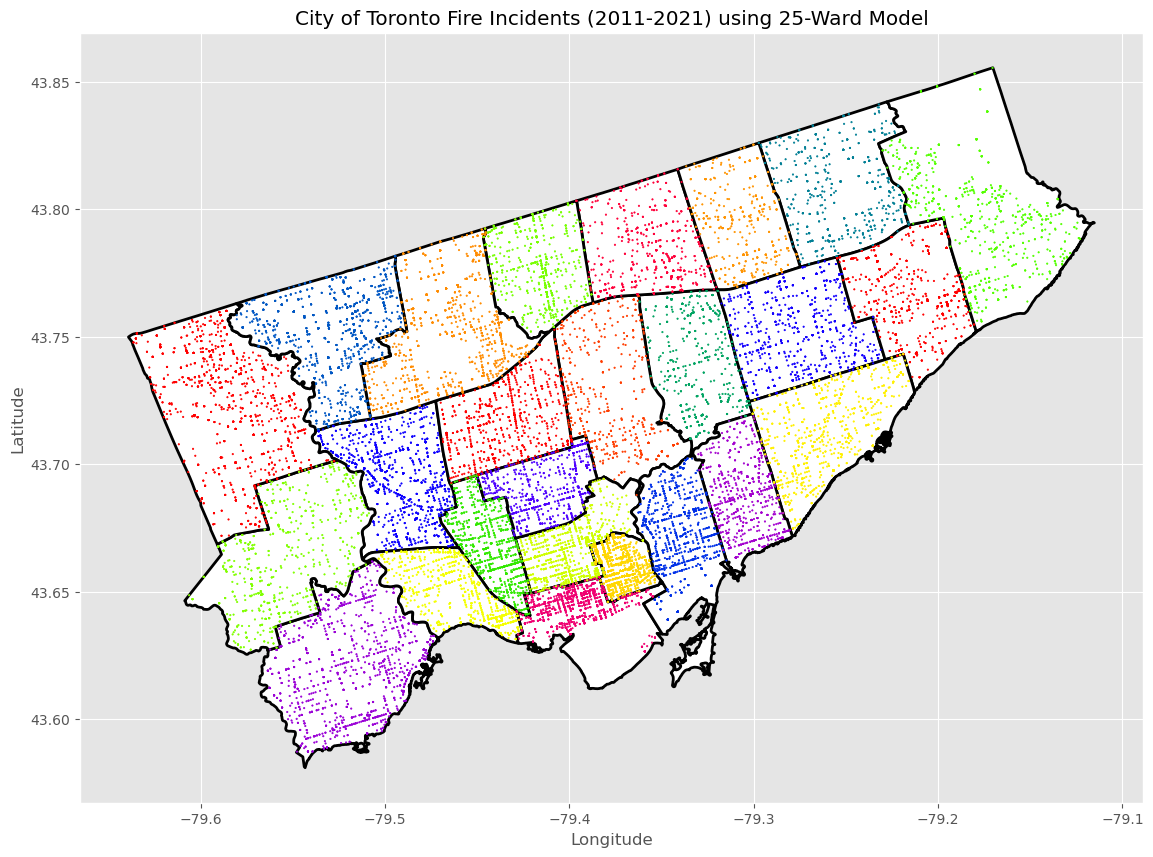

In [44]:
plot_map(wards, fireward, "New_Ward", "City of Toronto Fire Incidents (2011-2021) using 25-Ward Model");
plt.savefig('images/25wards.png', bbox_inches='tight')

## 5 Exporting CSV <a id="5-exporting-csv"/>
In this notebook, we used `GeoPandas` to map each data point to their respective city ward in the 25-ward model based on their geographic coordinates. This was done to correct for inconsistencies in the `Incident_Ward` column due to the change in the number of city wards in 2018 from 44 to 25.

We can export our partly cleaned data set with updated ward labels into a `.csv` file to be used for further data preparation.

In [45]:
# Removing the extra columns and renaming the columns
# We can drop Incident_Ward and use New_Ward to analyze ward related statistics
del fireward["Incident_Ward"]
del fireward["geometry"]
del fireward["index_right"]

# Exporting file to csv
fireward.to_csv("data/New_Fire_Incident_Data.csv", index=False)

## 6 References <a id="6-references"/>

1. Toronto City Clerk's Office (2022, November 29). City Wards [Data set]. City of Toronto Open Data. Retrieved May 8, 2023 from https://open.toronto.ca/dataset/city-wards/

2. Toronto Fire Services (2023, May 8). Fire Incidents (January 1, 2011 - December 31, 2021) [Data set]. City of Toronto Open Data. Retrieved May 8, 2023 from https://open.toronto.ca/dataset/fire-incidents/

End of notebook